In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')

import matplotlib.pyplot as plt
import pandas as pd
#plt.rcParams['figure.figsize'] = [15, 15]
#size=18
#params = {'legend.fontsize': size,
#          'figure.figsize': (20,8),
#          'axes.labelsize': size,
#          'axes.titlesize': size,
#          'xtick.labelsize': size*0.75,
#          'ytick.labelsize': size*0.75,
#          'axes.titlepad': 25}
#plt.rcParams.update(params)

mpl.rcParams['figure.figsize'] = [12., 12.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = '40'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [4]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        self.name='GrowthModel'
        self.parameters = ModelParameterArray()      
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=10000,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=3,val_min=0.,val_max=10.,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-10.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [5]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time.date

In [6]:
def get_data(name='Confirmed',country='Italy',fake_error=False):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']==country]
    df=ts.to_pandas()
    
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>0
    
    #to get each time integer from 1 to N (rather than 0 N-1)
    #dates start from 1 not 0
    time=np.arange(1,len(t)+1)
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001
        
    data_table=Table([time[msk], y[msk], y_err, np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y'))
    return data

In [11]:
def plot_model(mcmc,model,data,t_start_model=None, t_stop_model=None, size=10,mcmc_samples=500, labels=None,label=''):
    
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10,6),sharex='col')
    
    
    if t_start_model is None:
        t_start_model = model.nu_min_fit
    
    if t_stop_model is None:
        t_stop_model = model.nu_max_fit
        
    #nu=np.linspace(t_start_model,t_stop_model,100)
    nu=np.arange(t_start_model,t_stop_model,1)
    mcmc.reset_to_best_fit()
    p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    y = np.zeros((size,nu.size))

    for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
        for ID_par,pi in  enumerate(mcmc.par_array):
            pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])
  
        y[ID] = model.eval(nu,get_model=True)
    
    #print(ID)
    y_min=np.amin(y, axis=0)
    y_max=np.amax(y, axis=0)
    axs[0].fill_between(nu,y_max,y_min,color='gray',alpha=0.3)
    
    mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    
    axs[0].plot(nu,y_bf,label= label+': Predicted\nlog10(R0)/tau=%3.3f'%p)
    
    axs[0].errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    axs[0].axvline(model.nu_min_fit,alpha=0.5)
    axs[0].axvline(model.nu_max_fit,alpha=0.5)
    
    
    locs, labels = plt.xticks()
    #add 100 days to final date in data
    delta_t=pd.date_range(data.time[-1], periods=100, freq='d')[1:]
    t=np.append(data.time,delta_t.date)
    delta_x=data.data['nu_data'][-1]+np.arange(1,len(t)-len(data.data['nu_data'])+1)
    #sfit letf by 1 to align time with x thicks 
    x=np.append(data.data['nu_data'],delta_x)-1
    print(len(t),len(x))
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(t,rotation=45)
    #axs[0].set_xlabel('date')
    axs[0].set_ylabel('Counts')
    axs[0].semilogy()
    axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    #axs[0].legend()
    axs[0].set_xlim(t_start_model-1,None)
    #axs[0].set_ylim(1E-3,None)
    axs[0].grid(True)
    #axs[1].semilogy(np.gradient(bfm.fit_Model.eval(nu,get_model=True)),label='model')
    
    #Model
    axs[1].plot(nu  ,np.gradient(y_bf,nu,edge_order=2 ),label='model')
    y_der = np.zeros((size,nu.size))
    for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
        y_der[ID] = np.gradient(y[ID],nu,edge_order=2) 
        
    y_min=np.amin(y_der, axis=0)
    y_max=np.amax(y_der, axis=0)    
    axs[1].fill_between(nu ,y_max  ,y_min  ,color='gray',alpha=0.3)
    
    axs[1].plot(data.data['nu_data']  ,np.gradient(data.data['nuFnu_data'],data.data['nu_data']),'o',label='data')
    
    axs[1].axvline(model.nu_min_fit,alpha=0.5)
    axs[1].axvline(model.nu_max_fit,alpha=0.5)    
    axs[1].semilogy()
    axs[1].set_xticklabels(t,rotation=45)
    axs[1].set_xlabel('date')
    axs[1].set_ylabel('derivative')
    axs[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    axs[1].grid(True)
    plt.tight_layout()
    fig.suptitle('input data from https://github.com/CSSEGISandData/COVID-19',y=1.)
    plt.subplots_adjust(hspace=.0)


In [12]:
from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler


In [13]:
def do_analysis(t_start,t_stop,t_start_model,t_stop_model,name,country='Italy',do_plot=True,mcmc_steps=500):

    data=get_data(name,country,fake_error=False)
    gm=GrowthModel()
    gm.nu_min=0
    gm.nu_max=100
    #Fix error on the last entry of the latest update of JH database
    data.data['nuFnu_data'][-1]=1016
    fm=FitModel(analytical=gm,name='test')
    bfm,mm=fit_SED(fm,data,nu_fit_start=t_start,nu_fit_stop=t_stop,minimizer='minuit',silent=True)
    log_R0_by_tau=np.log10(gm.parameters.R0.val)/gm.parameters.tau.val
    print('log10(R0)/tau',log_R0_by_tau)
    print('doubling time',np.log10(2)/log_R0_by_tau)

    bfm.fit_Model.show_best_fit_pars()
     
    mcmc=McmcSampler(bfm)
    mcmc.run_sampler(nwalkers=150,burnin=10,steps=mcmc_steps,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)
        
    if do_plot is True:
        plot_model(mcmc,bfm.fit_Model,data,t_start_model=t_start,t_stop_model= t_stop_model,label=name,size=100,mcmc_samples=100)
            
        
        
        
        

    return bfm,mcmc,data

  1%|          | 6/500 [00:00<00:09, 52.92it/s]

log10(R0)/tau 0.13651419897156716
doubling time 2.205118573245842
 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
GrowthModel  eta 1.441737e+01 2.647408e+01    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
GrowthModel   R0 1.596901e+00 1.047706e+00    -- 3.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  tau 1.489061e+00 1.978264e+00    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  t_0 1.986993e+01 5.907420e+00    -- 0.000000e+00 -1.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:08<00:00, 57.45it/s]

mcmc run done, with 1 threads took 8.73 seconds


<IPython.core.display.Javascript object>


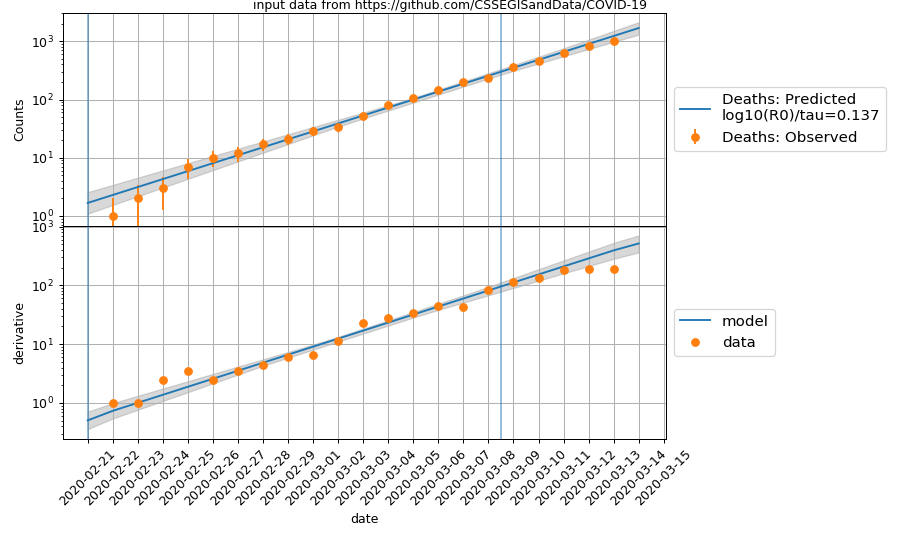

120 120


In [14]:
%matplotlib notebook
bfm,mcmc,data=do_analysis(t_start=30,t_stop=46.5,t_start_model=29,t_stop_model=53,name='Deaths',mcmc_steps=500)


<IPython.core.display.Javascript object>


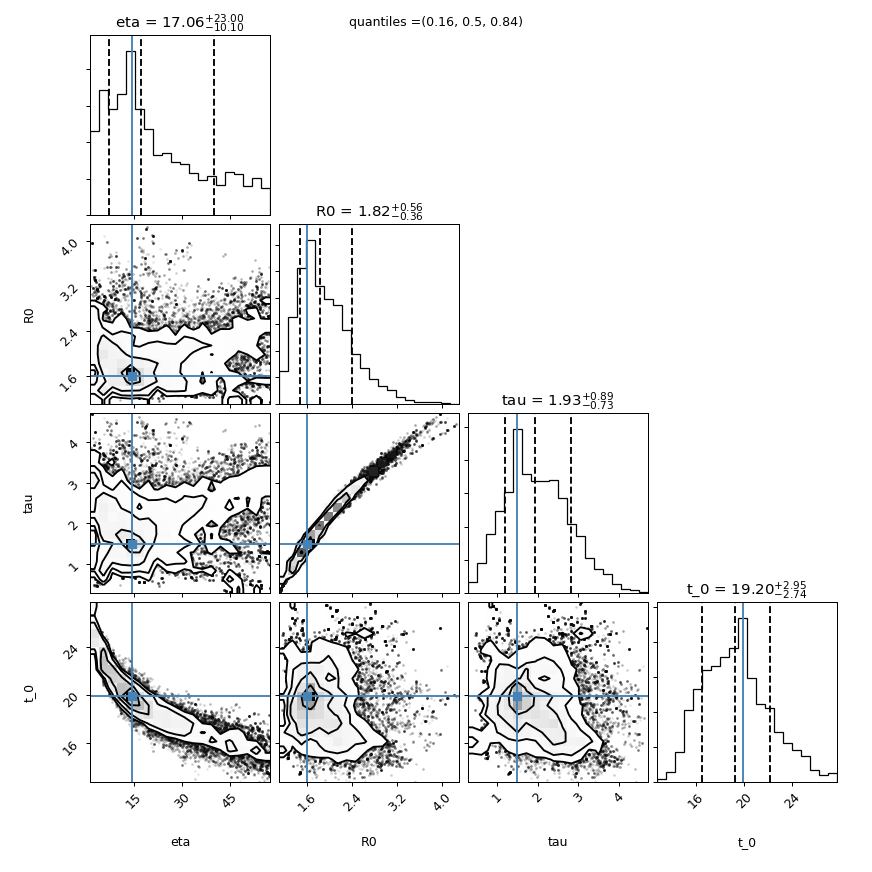

In [15]:
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))

In [ ]:
table=Table.read('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%'Deaths')
ts=table[table['Country/Region']=='Italy']
df=ts.to_pandas()

y=df.values
y=y.flatten()[4:].astype(np.int)
t=df.columns[4:]
msk=y>0

#to get each time integer from 1 to N (rather than 0 N-1)
#dates start from 1 not 0
time=np.arange(1,len(t)+1)

In [ ]:
time